# Karpathy's Introduction to Backpropagation in Neural Networks

I really want to cement my understanding of backpropagation in neural networks after going through Manning's [Stanford CS224N NLP with Deep Learning | Winter 2021 | Lecture 3 - Backprop and Neural Networks](https://www.youtube.com/watch?v=X0Jw4kgaFlg). 

From Karpathy's [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0) on YouTube.

NOTE: this will require the following libraries and/or packages...
- `graphviz` package for Linux, install with `sudo apt-get install graphviz`
- [`graphviz`](https://graphviz.readthedocs.io/en/stable/) - Python wrapper to `graphviz` package itself

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Intuition: Derivatives

#### Simple example: a function with a single input

Consider the simple function $f(x) = 3x^{2} - 4x + 5$.

In [2]:
# simple example: 1 input; a quadratic
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

What does that look like?

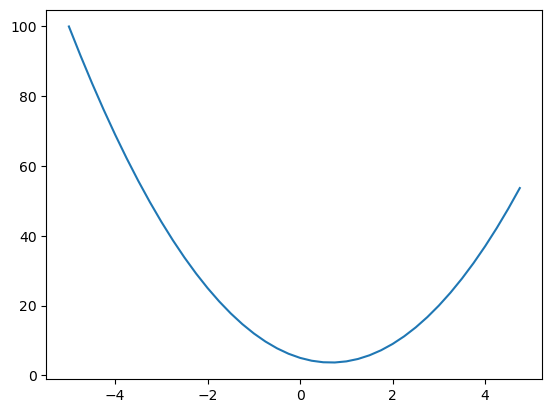

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

How does the slope of this function change at different inputs?

In [5]:
h = 0.0000001

# x = 3
# x = -3
x = 2/3

(f(x + h) - f(x)) / h

2.9753977059954195e-07

#### A more complex example: 3 inputs

Now see what happens to the slope of the function $f(x) = a * b + c$ when you increase the inputs individually by a small amount $h$.

In [6]:
# a more complex example: 3 inputs!
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

# inputs, fixed
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

# a += h
# b += h
c += h

d2 = a*b + c

print('d1: ', d1)
print('d2: ', d2)
print('slope: ', (d2 - d1) / h)

d1:  4.0
d2:  4.0001
slope:  0.9999999999976694


----

In [8]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __pow__(self, other):                        # self**other
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f"**{other}")
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        
        return out

    def __rmul__(self, other):                       # other * self
        return self * other

    def __truediv__(self, other):                    # self / other
        return self * other**-1

    def __neg__(self):                               # -self
        return self * -1

    def __sub__(self, other):                       # self - other
        return self + (-other)

    def __radd__(self, other):                      # other + self
        return self + other
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
            #self.grad = (1 - t**2) * out.grad       # <<< BUG!
        out._backward = _backward
        
        return out

    def exp(self):                                   # exp(self)
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
            #self.grad = out.data * out.grad         # <<< BUG!
        out._backward = _backward
        
        return out


    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()


In [9]:
a = Value(2.0)
b = Value(4.0)
a / b

Value(data=0.5)

In [10]:
math.exp(2.0)

7.38905609893065

In [11]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

print(L)

Value(data=-8.0)


In [12]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(
        format='svg',
        graph_attr={'rankdir': 'LR'}
    )
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular {'record'} node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record') 
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label = n._op)
            # and connect this node to it!
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connecty n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

### Back-prop by hand...

If you really are rusty, then scroll down to the Intuitive Explanation section of [the Wikipedia page on the Chain rule](https://en.wikipedia.org/wiki/Chain_rule).

But using our simple function graph above, it is really nothing more than this:

#### Starting from the far right

Calculate $\frac{dL}{dL}$

\begin{align}
\frac{dL}{dL} = 1
\end{align}

#### Moving to preceding multiplication operation

Since $L = d * f$ we calculate by the Chain rule:

\begin{align}
\frac{dL}{dd} = f = -2
\end{align}

... and ...

\begin{align}
\frac{dL}{df} = d = 4
\end{align}

#### Continuing backwards to the preceding addition operation

Since $d = e + c$ we calculate by the Chain rule:

\begin{align}
\frac{dL}{de} = \frac{dL}{dd} \frac{dd}{de} = -2 * 1 = -2
\end{align}

... and ...

\begin{align}
\frac{dL}{dc} = \frac{dL}{dd} \frac{dd}{dc} = -2 * 1 = -2
\end{align}

#### Finish moving backwards to the initial multiplication operation

Since $3 = a * b$ we calculate once more by the Chain rule:

\begin{align}
\frac{dL}{da} = \frac{dL}{de} \frac{de}{da} = -2 * -3 = 6
\end{align}

... and lastly ...

\begin{align}
\frac{dL}{db} = \frac{dL}{de} \frac{de}{db} = -2 * 2 = -4
\end{align}


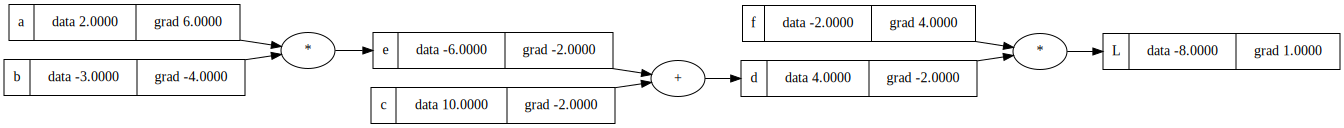

In [13]:
# OK, now let's manually initialize the gradients for the nodes in our function graph

L.grad = 1.0

d.grad = -2.0
f.grad =  4.0

c.grad = -2.0
e.grad = -2.0

a.grad =  6.0
b.grad = -4.0

draw_dot(L)

Nudging $a$, $b$, $c$ and $f$ _in the direction of the gradient_, we should then see an increase in $L$...

An interesting note, you may have noticed that with an _addition_ operation like $d = e + c$ above, the gradients flowing in are merely distributed to the child nodes at that layer.

You can see that using the following function.

In [14]:
def lol():
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    
    c = Value(10.0, label='c')
    #c.data += h
    
    e = a*b; e.label = 'e'
    e.data += h
    
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    
    print((L2 - L1) / h)
    
lol()

-1.9999999999953388


## Now Consider A Single Neuron

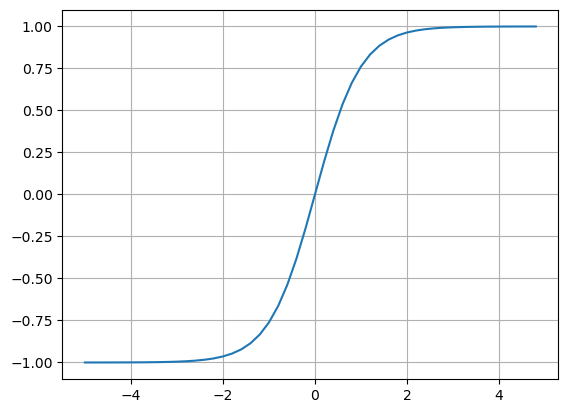

In [15]:
plt.plot(
    np.arange(-5,5,0.2), 
    np.tanh(np.arange(-5,5,0.2))
)

plt.grid()

In [16]:
# inputs x1, x2
x1 = Value( 2.0, label='x1')
x2 = Value( 0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value( 1.0, label='w2')

# bias of the neuron
b = Value( 6.8813735870195432, label= 'b')
    
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2* 2'

n = x1w1x2w2 + b; n.label = 'n'

# output o
o = n.tanh(); o.label = 'o'
o.backward()

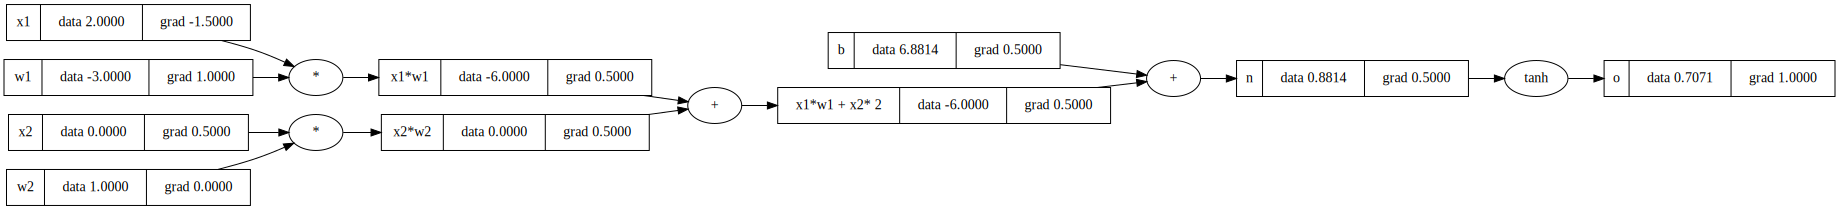

In [17]:
draw_dot(o)

### Manually calculate the gradients

We start from the far right, $o = \text{tanh}(n)$. 

The gradient of this node is constant, $1$.


What is the local derivative $\frac{do}{dn} tanh(n)$?

Well, just check out [the Derivatives section of the page on Hyperbolic functions on Wikipedia!](https://en.wikipedia.org/wiki/Hyperbolic_functions#Derivativ)

Continuing left-wards...

Remember what we just said about addition operations and derivatives?

Well, $n = x1w1x2w2 + b$, so we have:

Moving to the preceding node to the left once more, we have: $x1w1x2w2 = x1w1 + x2w2$.

Another addition operation!

And moving once more to the left, we have:

$x1w1 = x1 * w1$

$x2w2 = x2*w2$

#### How could we do the above, but automatically?

Add an additional implementation detail to the \_\_`add`\_\_, \_\_`mul`\_\_, and `tanh` methods of `Value` that calculates the local derivatives.


Using a topological graph, we can arrange the nodes in our function graph so that as we move backwards through the graph, we will be sure to have sequentially deal with all the nodes to the right in the correct ordering so that we can correctly calculate the local derivatives as we sweep towards the left.

c.f. [Harish Reddy Konduru's blog post on Topological Sort - in typescript and C#](https://medium.com/@konduruharish/topological-sort-in-typescript-and-c-6d5ecc4bad95).

In [18]:
# base case!
o.grad = 1.0

topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)
#topo

for node in reversed(topo):
    node._backward()

#### Putting it all together!

Now let's move the topological sorting and calls to `_backward` to be a part of the `Value` object!

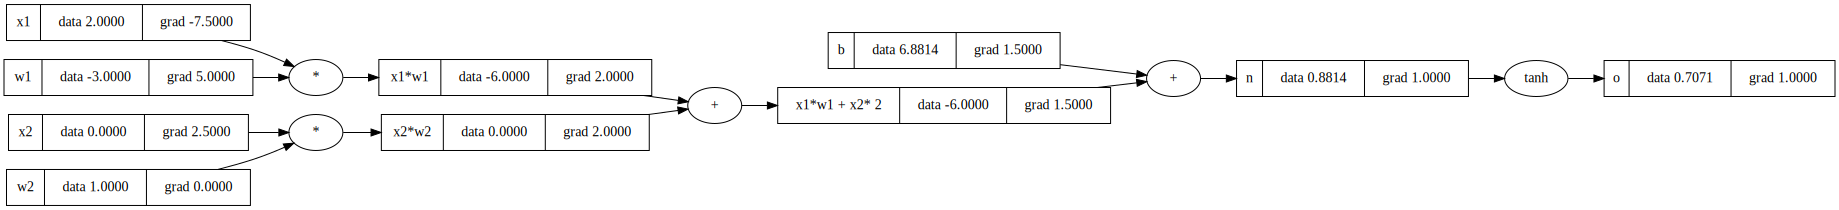

In [19]:
draw_dot(o)

In [20]:
o.backward()

----

## A latent bug in our gradient calculations?

#### Ex. 1

Check that gradient for `a`. That's not right!

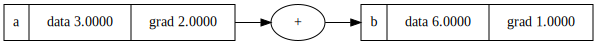

In [21]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'

b.backward()

draw_dot(b)

#### Ex.2 

Those gradients can't be correct!

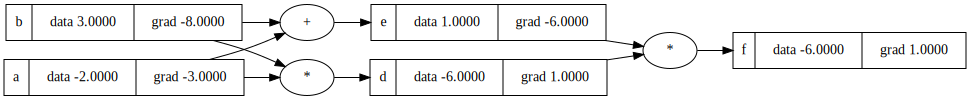

In [22]:
a = Value(-2.0, label='a')
b = Value( 3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()

draw_dot(f)

#### Root cause: we are _setting_ the gradients not _accumulating them_!

Up until now (or at least, up until the point we started using nodes _more than once_, we assiged the gradient values.

In the case where a node is used more than once, we were making this assignment _twice_, over-writing the original gradient value with the next gradient value (which just happens to be the same in an addition operation).

The solution: don't merely assign using the `=` operator; _accumulate_ with the `+=` operator!

c.f. the [Multivariable case section of the Chain rule page on Wikipedia](https://en.wikipedia.org/wiki/Chain_rule#Multivariable_case).

----

## Fleshing Out Mathematical Operations in `Value`

Now, in our implementation of `Value` up until this point, we simply encapsulated the the entirety of $tanh$ into a single method. What we've got now is this:

\begin{align}
    \text{tanh} \phantom . x &= \frac{\text{sinh} \phantom . x}{\text{cosh} \phantom . x} \\\\
    &= \frac{e^{2x} - 1}{e^{2x} + 1}
\end{align}

But as Karpathy points out, we could take things a step further and decompose that operation (in order of the video):

* enhance \_\_`add`\_\_ to allow for `a` + 1 (and vice-versa with \_\_`radd`\_\_)
* enhance \_\_`mul`\_\_ to allow for `a` * 2 (and vice-versa with \_\_`rmul`\_\_)
* implement `exp`, including the calculation for local gradient (recall $\frac{d}{dx} e^{x} = e^{x}$)
* futher decompose `division` as $a / b \Rightarrow a * b^{-1}$, treating it as `multiplication`
   * thus we implement \_\_`truediv`\_\_
* we also implement \_\_`pow`\_\_ for raising `self` to `other` (`other` is `int` or `float`)
* and why don't we also implement `subtraction` as $a - b = a + (-b)$
   * implement \_\_`neg`\_\_ for `negation`, i.e. $-b$
   * implement \_\_`sub`\_\_ for defining `subtraction` as `addition` with `negation`

As an interesting exercise, let's go ahead and do just that.

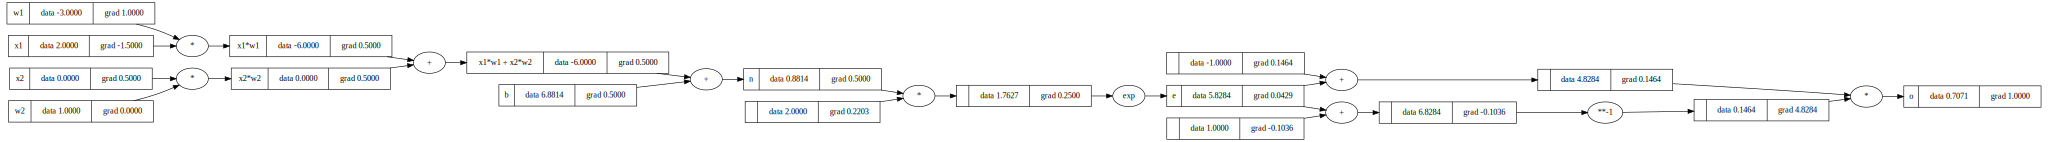

In [23]:
# inputs x1, x2
x1 = Value( 2.0, label='x1')
x2 = Value( 0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value( 1.0, label='w2')

# bias of the neuron
b = Value( 6.8813735870195432, label= 'b')
    
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

# ========
# output o
e = (2*n).exp(); e.label = 'e'
o = (e - 1) / (e + 1)
# ========

o.label = 'o'
o.backward()

draw_dot(o)

----

## And Now, in PyTorch!

Here is the equivalent of the former in PyTorch.

Karpathy modeled `micrograd` on the PyTorch implementations.

In [24]:
import torch

x1 = torch.Tensor([2.0]).double()                  ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                  ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                 ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                  ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()    ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("----")
print("x1 ", x1.grad.item())
print("w1 ", w1.grad.item())
print("x2 ", x2.grad.item())
print("w2 ", w2.grad.item())

0.7071066904050358
----
x1  -1.5000003851533106
w1  1.0000002567688737
x2  0.5000001283844369
w2  0.0


#### NOTES

##### Why cast the `torch.Tensor` values to `double`?

Python uses double precision to represent floating points, while in PyTorch the default is `torch.float32`. Karpathy does this only keep things consistent.



In [25]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [26]:
x1.grad.item()

-1.5000003851533106

----

In [27]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        #params = []
        #for neuron in self.neurons:
        #    params.extend(neuron.parameters())
        #return params  
        return [
            p
            for neuron in self.neurons
            for p in neuron.parameters()
        ]


class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [28]:
# input layer size: 3
#
# MPL has three layers internally
# - first hidden layer has size 4
# - 2nd hidden layer has size 4
# - last layer (output layer) has size 1
#
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.1752795270515894)

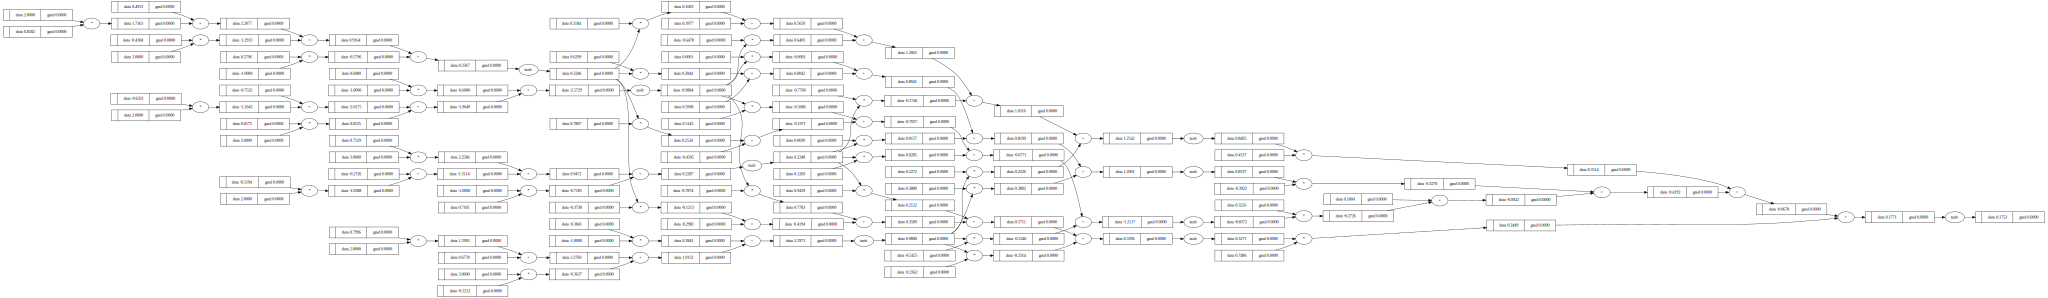

In [29]:
draw_dot(n(x))

In [30]:
[len(l.neurons) for l in n.layers]

[4, 4, 1]

----

In [31]:
# simple 4-element dataset
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [
    1.0,
    -1.0,
    -1.0,
    1.0
]


ypred = [n(x) for x in xs]
ypred

[Value(data=0.1752795270515894),
 Value(data=-0.5225169567693448),
 Value(data=0.21010700021726086),
 Value(data=-0.3451221248799424)]

In [32]:
# our implementation of gradient descent!
for k in range(20):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)])
    
    # backward pass
    # ... don't forget! 
    #     we need to .zero_grad() before .backward()!
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad
        
    print(k, loss.data)     
    

0 4.181866397889407
1 2.8504190473213358
2 1.886451700910123
3 1.1462014895148884
4 0.7328776476578898
5 0.510737441750489
6 0.3809627080663006
7 0.29748904138930965
8 0.24065326138319992
9 0.20014185753737607
10 0.17014825512777157
11 0.14723325746468968
12 0.12926327474711274
13 0.11485937208071426
14 0.10309794963258888
15 0.0933408773826673
16 0.08513516974126205
17 0.07815156487839926
18 0.07214569548776208
19 0.06693282799172186


In [33]:
ypred

[Value(data=0.904571260813673),
 Value(data=-0.8297474130203828),
 Value(data=-0.9019663098144067),
 Value(data=0.8613290371261062)]